## Import Package

In [ ]:
%run ./ESE527_project_setup.ipynb

# Predictive Analysis

### Remove outlier by using Isolaed Forest 

### Split dataset

In [2]:
data_if=data_if.dropna(axis=1)

In [3]:
features=data_if.drop(['Rating', 'Rating Interval'],axis=1)
label=data_if['Rating Interval']
#standardized_features=Standardization(features)
train_X,test_X,train_Y,test_Y=train_test_split(features,label,test_size=0.2,random_state=527)
smote = SMOTE()
# Fit and apply SMOTE
train_X, train_Y = smote.fit_resample(train_X, train_Y)

In [4]:
lasso = Lasso(alpha=0.01)
# Fit Lasso model on the training data
lasso.fit(train_X, train_Y)
# Get the coefficients
coefficients = pd.Series(lasso.coef_, index=train_X.columns)
# Filter features with non-zero coefficients
selected_features = coefficients[coefficients != 0].index.tolist()
print('Selected features:', selected_features)
print('Number of selected features:', len(selected_features))
train_X=train_X[selected_features]
test_X=test_X[selected_features]

Selected features: ['Reviews', 'Size', 'Installs', 'Price', 'days_since_last_update', 'Category_PERSONALIZATION', 'Category_TOOLS', 'Content Rating_Everyone', 'Genres_Education', 'Genres_Personalization', 'Genres_Tools']
Number of selected features: 11


In [5]:
model = LogisticRegression(random_state=0)
# Define the grid of values for hyperparameters
params = {
    'C': [0.01,0.1,1,10,100,1000],
    'penalty': ['l2'],
    'solver': ['newton-cg','lbfgs','liblinear','sag']
}
train_X=train_X[selected_features]
test_X=test_X[selected_features]
# Define GridSearchCV
LR_clf = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=1)
LR_clf.fit(train_X, train_Y)
# Best parameters and best score
print("Best parameters:", LR_clf.best_params_)
print("Best score:", LR_clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.46851969486746575


In [6]:
# Best model:
LR_clf.best_estimator_.score(test_X[selected_features],test_Y)

0.42658875091307524

Accuracy: 0.42658875091307524
Precision: 0.5106997106096961
Recall: 0.42658875091307524
F1 Score: 0.4007913863960977


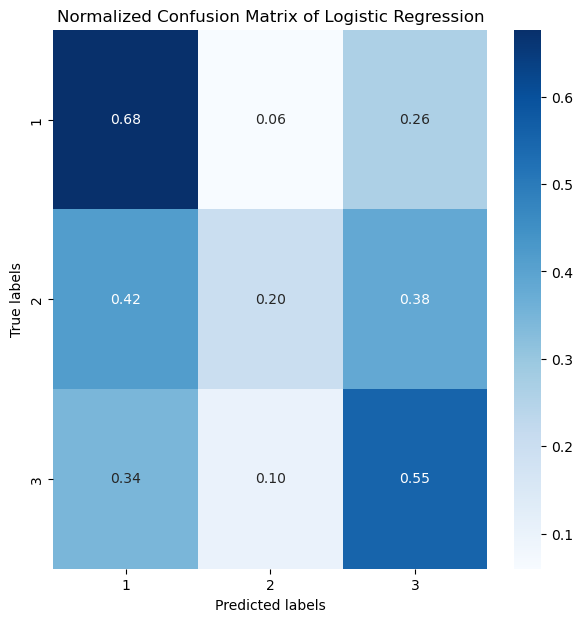

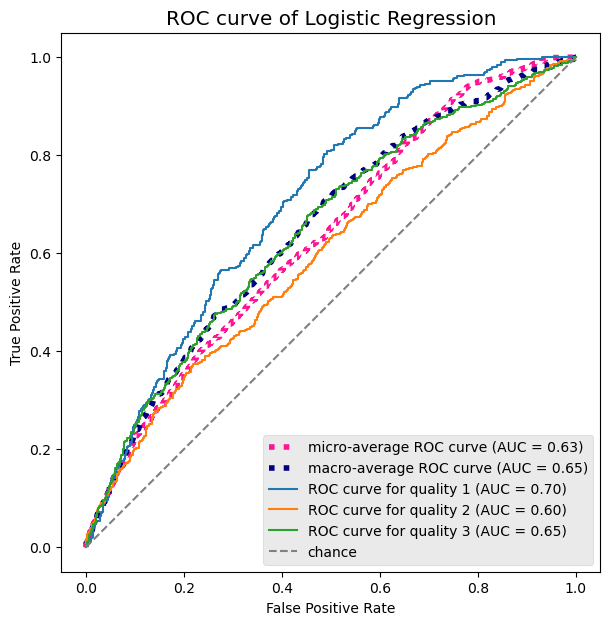

In [7]:
cm(test_X,test_Y,LR_clf,'Logistic Regression')
ROC(train_Y,test_Y,LR_clf,'Logistic Regression',)

### Random Forest

In [8]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'criterion': trial.suggest_categorical('criterion',['gini', 'entropy']),
        'max_features': trial.suggest_int('max_features', 1, 10),
    }
    RF_clf = RandomForestClassifier(**params)
    RF_clf.fit(features, label)
    k_folds = 3
    cv_scores = cross_val_score(RF_clf, features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, show_progress_bar=True)

# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-05-05 17:13:55,652] A new study created in memory with name: no-name-b68cca0f-75d7-4849-a7a0-2a976f6ae213


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-05-05 17:14:02,982] Trial 0 finished with value: 0.4832577021979177 and parameters: {'n_estimators': 289, 'criterion': 'gini', 'max_features': 1}. Best is trial 0 with value: 0.4832577021979177.
[I 2024-05-05 17:14:17,315] Trial 1 finished with value: 0.4888126168116477 and parameters: {'n_estimators': 551, 'criterion': 'gini', 'max_features': 3}. Best is trial 1 with value: 0.4888126168116477.
[I 2024-05-05 17:14:22,146] Trial 2 finished with value: 0.49115186219238 and parameters: {'n_estimators': 171, 'criterion': 'gini', 'max_features': 5}. Best is trial 2 with value: 0.49115186219238.
[I 2024-05-05 17:14:31,716] Trial 3 finished with value: 0.4901289831329749 and parameters: {'n_estimators': 333, 'criterion': 'gini', 'max_features': 6}. Best is trial 2 with value: 0.49115186219238.
[I 2024-05-05 17:14:41,746] Trial 4 finished with value: 0.48720545518406566 and parameters: {'n_estimators': 333, 'criterion': 'entropy', 'max_features': 3}. Best is trial 2 with value: 0.49115

In [9]:
clf_RF= RandomForestClassifier(**best_params)
clf_RF.fit(train_X, train_Y)
y_pred=clf_RF.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred)
accuracy

0.5281227173119065

Accuracy: 0.5281227173119065
Precision: 0.5247686023284458
Recall: 0.5281227173119065
F1 Score: 0.5256015760827046


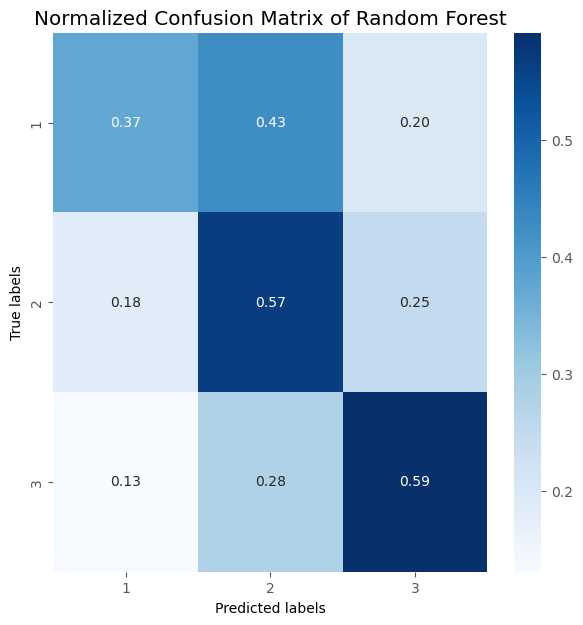

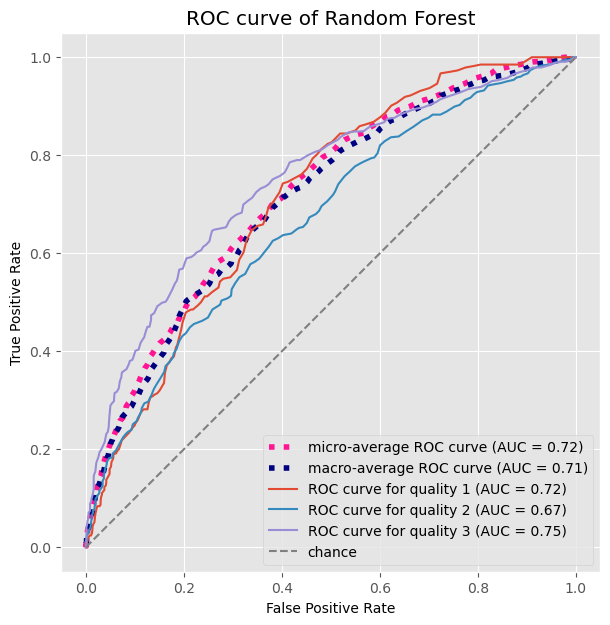

In [10]:
cm(test_X,test_Y,clf_RF,'Random Forest')
ROC(train_Y,test_Y,clf_RF,'Random Forest')

### Lightgbm

In [12]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-05-05 17:15:14,419] A new study created in memory with name: no-name-0868b57a-593c-4fef-a0e6-e68c926b9745


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9384283520123838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9384283520123838
[LightGBM] [Warning] bagging_fraction is set=0.5828793459334772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5828793459334772
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9384283520123838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9384283520123838
[LightGBM] [Warning] bagging_fraction is set=0.5828793459334772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5828793459334772
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds

In [13]:
clf_lgbm= lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(train_X, train_Y)
y_pred=clf_lgbm.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred)
accuracy

[LightGBM] [Warning] feature_fraction is set=0.9346426814058882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9346426814058882
[LightGBM] [Warning] bagging_fraction is set=0.9928952533467958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9928952533467958
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9346426814058882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9346426814058882
[LightGBM] [Warning] bagging_fraction is set=0.9928952533467958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9928952533467958
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds

0.5427319211102994

In [14]:
importances = clf_lgbm.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) days_since_last_update         10518.000000
 2) Reviews                        10279.000000
 3) Size                           9808.000000
 4) Installs                       3467.000000
 5) Content Rating_Everyone        1320.000000
 6) Category_TOOLS                 771.000000
 7) Price                          702.000000
 8) Genres_Education               587.000000
 9) Category_PERSONALIZATION       434.000000
10) Genres_Tools                   73.000000
11) Genres_Personalization         57.000000


[LightGBM] [Warning] feature_fraction is set=0.9346426814058882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9346426814058882
[LightGBM] [Warning] bagging_fraction is set=0.9928952533467958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9928952533467958
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Accuracy: 0.5427319211102994
Precision: 0.5427665960982803
Recall: 0.5427319211102994
F1 Score: 0.542030323651046


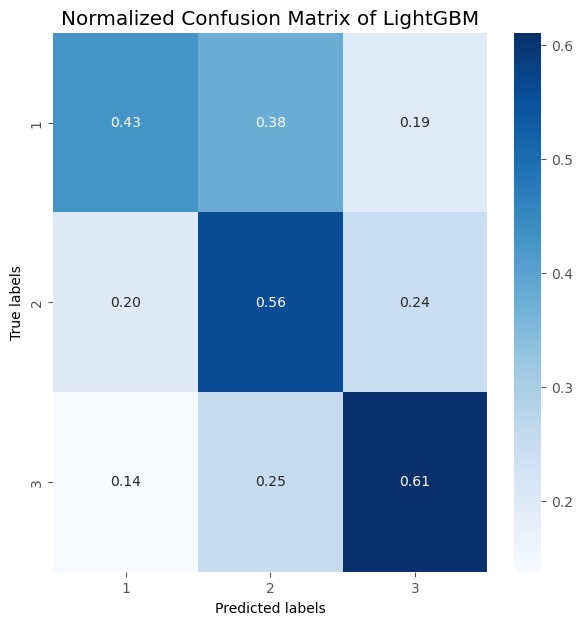

[LightGBM] [Warning] feature_fraction is set=0.9346426814058882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9346426814058882
[LightGBM] [Warning] bagging_fraction is set=0.9928952533467958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9928952533467958
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


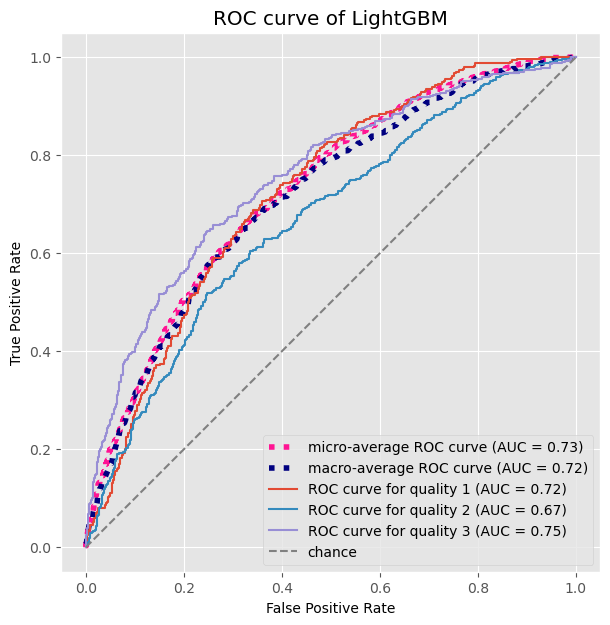

In [15]:
cm(test_X,test_Y,clf_lgbm,'LightGBM')
ROC(train_Y,test_Y,clf_lgbm,'LightGBM')